In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import linear_model
from scipy import stats
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.transform import resize
import matplotlib.patches as patches
from keras.models import Sequential
from scipy.stats.stats import pearsonr
from scipy.ndimage.filters import gaussian_filter as gf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

from hyss_util import *

2023-07-28 00:32:24.831655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 00:32:25.030273: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-28 00:32:25.520210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-28 00:32:25.520264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
plt.style.use("bmh")

# -- set grayscale to be the default color map
plt.rcParams["image.cmap"] = "gist_gray"
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams['axes.titlepad'] = 0 

In [4]:
# # -- TECHNOLOGY TYPING WITH COEF VALUE
# # -- load raw spec data for both scan
# hsi0_spec = np.load("../output/hsi0_overlap_cnn_allwave_bridge.npy").T
# hsi1_spec = np.load("../output/hsi1_overlap_cnn_allwave_bridge.npy").T


# # -- load spec location
# spec_loc_hsi0 = np.load("../output/hsi0_overlap_location_bridge.npy")
# spec_loc_hsi1 = np.load("../output/hsi1_overlap_location_bridge.npy")


# # -- load waves range for both scans
# waves0 = np.load("../output/graham_hall_upload/cube0_waves_range.npy")
# waves1 = np.load("../output/graham_hall_upload/cube1_waves_range.npy")

# # -- load templates, waves, and names
# spectra = np.load("../output/final_spectra_20.npy").T
# names = np.load("../output/final_name_20.npy")
# wavelengths = np.load("../output/graham_hall_upload/lspdd_lab_spectra_wavelengths.npy")

In [5]:
# # -- interpolate the hsi0 spectra 
# hsi0_inter = np.empty((len(hsi0_spec), len(waves1)))
# for i in range(0, len(hsi0_spec)):
#     interp = np.interp(waves1, waves0, (hsi0_spec)[i])
#     hsi0_inter[i,:] = (interp)

In [6]:
# # -- get coef value for each sources
# def get_coef(spec_pixel, spec_loc):

#   """
#   Read "active" pixel in either 2013 scan or 2018 scan

#   Parameters:
#   ----------
#   spec_pixel: two dimentional numpy array
#              raw spectra of all "active" pixel

#   spec_loc: two dimentional numpy array
#             "active" pixels' location

#   Returns:
#   -------

#   coor: two dimentional numpy array
#        20 correlation values with all "active" pixel
#   fit: a dataframe
#       Columns: The index of the highest correlation value,
#        The highest correlation value, Lighting technology name, 
#        Location(x and y)

#   """

#   # -- load lab spectra, their lighting technology names and wavelength
#   names = np.load("../output/final_name_20.npy")
#   spectra = np.load("../output/final_spectra_20.npy")
#   wavelengths = np.load("../output/graham_hall_upload/lspdd_lab_spectra_wavelengths.npy")

#   # -- interpolate the NOAA and lspdd lab spectra wavelengths (x-coordinates) to the wavelengths of the HSI scan
#   spectra2 = np.empty((len(spectra), len(waves1)))
#   for i in range(0, len(spectra)):
#     interp = np.interp(waves1, wavelengths, spectra[i])
#     spectra2[i,:] = (interp)

#   # -- standardize lab spectra data
#   spectra2_st = np.empty(spectra2.shape)
#   for i in range(0, len(spectra2)):
#     st = (spectra2[i] - spectra2[i].mean()) / spectra2[i].std()
#     spectra2_st[i, :] = st

#   # -- standardize "active" sources' spectra data  
#   spec_st = np.empty(spec_pixel.shape)
#   for i in range(0, spec_pixel.shape[0]):
#     st = (spec_pixel[i, :] - spec_pixel[i, :].mean()) / spec_pixel[i, :].std()
#     spec_st[i, :] = st

#   # -- coorelate spectrum of each pixel with NOAA lab spectra
#   coor = np.empty((spec_pixel.shape[0], len(spectra2)))
#   for i in range(0, spec_pixel.shape[0]):
#     for j in range(0, len(spectra2)):
#       coef, pvalue = pearsonr(spectra2[j, :], spec_st[i, :])
#       coor[i, j] = coef

#   # -- get maximum coorelation value and index for each pixel
#   fit = np.empty((spec_pixel.shape[0], 2))
#   for i in range(0, spec_pixel.shape[0]):
#     maxIndex = np.argmax(coor[i, :])
#     fit[i, 0] = maxIndex
#     maxValue = np.amax(coor[i, :])
#     fit[i, 1] = maxValue
  
#   # -- get corresponding lighting technology name with maximum correlation value
#   lnames = []
#   for num in fit[:, 0]:
#     lnames.append(names[num.astype("int")])

#   # -- change it to dataframe and include source locations
#   fit = pd.DataFrame(fit)
#   fit["name"] = lnames
#   fit["x"] = spec_loc[:, 1]
#   fit["y"] = spec_loc[:, 0]
  
#   return coor, fit

In [7]:
# # -- get correlation value for "active" sources in both images
# coor_hsi0, fit_hsi0 = get_coef(hsi0_inter, spec_loc_hsi0)
# coor_hsi1, fit_hsi1 = get_coef(hsi1_spec, spec_loc_hsi1)

In [14]:
# # -- get plotted lighting technologies name 
# def get_lighting_type(fit, thre):

#   """
#   Print lighting types according to their coor values

#   Parameters:
#   ----------
#   fit: a dataframe
#       Columns: The index of the highest correlation value,
#        The highest correlation value, Lighting technology name, 
#        Location(x and y)
  
#   thre: the threshold of keeping this pixel as source

#   Returns:
#   -------
#   Six lighting technologies and their location,
#   High_Pressure_Sodium, LED, Incandescent, Metal_Halide, Fluorescent, OIL.
  
#   """

#   # -- thresholding correlation value
#   sub_lighting = fit[fit[1] > thre]
  
#   # -- get the high pressure soidum category
#   High_Pressure_Sodium0 = sub_lighting[sub_lighting["name"].str.contains("HPS")]
#   High_Pressure_Sodium1= sub_lighting[sub_lighting["name"].str.contains("High_Pressure_Sodium")]
#   High_Pressure_Sodium = pd.concat([High_Pressure_Sodium0,High_Pressure_Sodium1])

#   # -- get the LED category
#   LED = sub_lighting[sub_lighting["name"].str.contains("LED")]

#   # -- get the Incandescent category
#   Incandescent0 = sub_lighting[sub_lighting["name"].str.contains("Incandescent")]
#   Incandescent1 = sub_lighting[sub_lighting["name"].str.contains("INC")]
#   Incandescent = pd.concat([Incandescent0,Incandescent1])

#   # -- get the Metal_Halide category
#   Metal_Halide0 = sub_lighting[sub_lighting["name"].str.contains("Metal_Halide")]
#   Metal_Halide1 = sub_lighting[sub_lighting["name"].str.contains("MH")]
#   Metal_Halide = pd.concat([Metal_Halide0,Metal_Halide1])

#   # -- get the Fluorescent category
#   Fluorescent0 = sub_lighting[sub_lighting["name"].str.contains("CFL")]
#   Fluorescent1 = sub_lighting[sub_lighting["name"].str.contains("Fluorescent")]
#   Fluorescent = pd.concat([Fluorescent0,Fluorescent1])

#   # -- get the OIL category
#   OIL = sub_lighting[sub_lighting["name"].str.contains("Oil")]

#   return High_Pressure_Sodium, LED, Incandescent, Metal_Halide, Fluorescent, OIL

In [15]:
# # -- get plotted lighting technology name and location
# High_Pressure_Sodium_hsi1, Light_emitting_diode_hsi1, Incandescent_hsi1, Metal_Halide_hsi1, Fluorescent_hsi1, OIL_hsi1 = get_lighting_type(fit_hsi1, 0.25)
# High_Pressure_Sodium_hsi0, Light_emitting_diode_hsi0, Incandescent_hsi0, Metal_Halide_hsi0, Fluorescent_hsi0, OIL_hsi0 = get_lighting_type(fit_hsi0, 0.25)

In [5]:
# # -- load 2013 and 2015 images
# imgL_hsi0 = np.load("../output/graham_hall_upload/imgL0_overlap.npy")
# imgL_hsi1 = np.load("../output/img_L1_fnl.npy")

# # -- load waves range for both scans
# waves0 = np.load("../output/graham_hall_upload/cube0_waves_range.npy")
# waves1 = np.load("../output/graham_hall_upload/cube1_waves_range.npy")

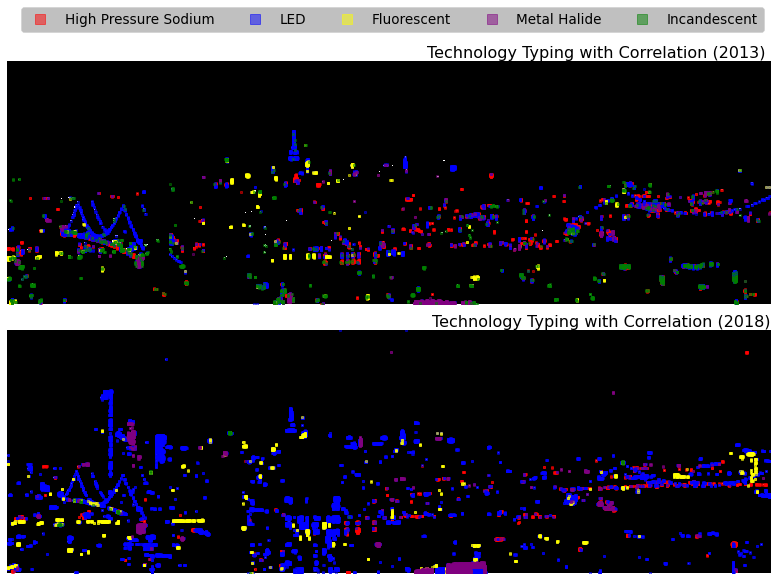

In [17]:
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
# ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
# ax[0].plot(High_Pressure_Sodium_hsi0["x"], High_Pressure_Sodium_hsi0["y"], c = "red", label = 'High Pressure Sodium', alpha = 0.5,marker="o", ms=2.5, linestyle='')

# ax[0].plot(Light_emitting_diode_hsi0["x"], Light_emitting_diode_hsi0["y"], c = "blue",  marker="o", label = 'LED', alpha = 0.5 , ms=2.5, linestyle='' )
# ax[0].plot(Fluorescent_hsi0["x"], Fluorescent_hsi0["y"], c = "yellow", label = 'Fluorescent', alpha = 0.5, marker="o",ms=2.5, linestyle='')
# ax[0].plot(Metal_Halide_hsi0["x"], Metal_Halide_hsi0["y"], c = "purple", label = 'Metal Halide', alpha = 0.5,marker="o", ms=2.5, linestyle='')
# ax[0].plot(Incandescent_hsi0["x"], Incandescent_hsi0["y"], c = "green", label = 'Incandescent', alpha = 0.5,marker="o", ms=2.5, linestyle='')

# ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 13.6, facecolor = "silver", framealpha = 1)
# ax[0].set_title("Technology Typing with Correlation (2013) ", loc = "right", fontsize = 16)
# ax[0].axis('off')



# ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
# ax[1].plot(High_Pressure_Sodium_hsi1["x"], High_Pressure_Sodium_hsi1["y"], c = "red", label = 'High_Pressure_Sodium', alpha = 0.5, marker="s",ms=2.5, linestyle='')

# ax[1].plot(Light_emitting_diode_hsi1["x"], Light_emitting_diode_hsi1["y"], c = "blue", label = 'LED', alpha = 0.5, marker="s",ms=2.5, linestyle='')
# ax[1].plot(Fluorescent_hsi1["x"], Fluorescent_hsi1["y"], c = "yellow", label = 'Fluorescent', alpha = 0.5,marker="s", ms=2.5, linestyle='')
# ax[1].plot(Metal_Halide_hsi1["x"], Metal_Halide_hsi1["y"], c = "purple", label = 'Metal_Halide', alpha = 0.5, marker="s",ms=2.5, linestyle='')
# ax[1].plot(Incandescent_hsi1["x"], Incandescent_hsi1["y"], c = "green", label = 'Incandescent', alpha = 0.5, marker="s",ms=2.5, linestyle='')




# # ax.scatter(OIL["x"], OIL["y"], c = "pink", label = 'Halogen', alpha = 0.5, s=5)

# #ax[1].legend(loc = "upper left")
# ax[1].set_title("Technology Typing with Correlation (2018)", loc = "right", fontsize = 16)
# ax[1].axis('off')
# fig.tight_layout()

In [4]:
# -- 1D-CNN MODEL
# -- load source spectra and type for both hsi0 and hsi1
cnn_hsi0 = np.load("../output/graham_hall_upload/hsi0spec_labeled.npy", allow_pickle=True)
cnn_hsi1 = np.load("../output/graham_hall_upload/hsi1spec_labeled.npy", allow_pickle=True)

# -- targ
targ_hsi0 = np.load("../output/graham_hall_upload/hsi0_labeled_targ.npy", allow_pickle=True)
targ_hsi1 = np.load("../output/graham_hall_upload/hsi1_labeled_targ.npy", allow_pickle=True)

# -- location
loc_hsi0 = np.load("../output/upload_to_dfam/hsi0spec_loc_all.npy")
loc_hsi1 = np.load("../output/upload_to_dfam/hsi1spec_location_all.npy")

# -- load waves range for both scans
waves0 = np.load("../output/graham_hall_upload/cube0_waves_range.npy")
waves1 = np.load("../output/graham_hall_upload/cube1_waves_range.npy")


In [6]:
spec_loc_hsi0 = pd.DataFrame(loc_hsi0)
spec_loc_hsi0["targ"] = targ_hsi0
spec_loc_hsi0["targ"] = spec_loc_hsi0["targ"].replace("unknown", "Unknown")

spec_loc_hsi0.rename({0: 'y', 1: 'x'}, axis=1, inplace=True)
spec_loc_hsi0

,y,x,targ
0,205.0,407.0,LED
1,211.0,407.0,LED
2,222.0,407.0,LED
3,222.0,408.0,LED
4,229.0,407.0,LED
...,...,...,...
708,641.0,661.0,Incandescent
709,642.0,661.0,Incandescent
710,667.0,577.0,Incandescent
711,676.0,833.0,Incandescent


In [7]:
spec_loc_hsi1 = pd.DataFrame(loc_hsi1)
spec_loc_hsi1["targ"] = targ_hsi1
spec_loc_hsi1["targ"] = spec_loc_hsi1["targ"].replace("unknown", "Unknown")

spec_loc_hsi1.rename({0: 'y', 1: 'x'}, axis=1, inplace=True)
spec_loc_hsi1

,y,x,targ
0,174.0,137.0,LED
1,174.0,146.0,LED
2,174.0,147.0,LED
3,175.0,138.0,LED
4,178.0,139.0,LED
...,...,...,...
611,511.0,148.0,Incandescent
612,519.0,157.0,Incandescent
613,547.0,227.0,Incandescent
614,672.0,214.0,Incandescent


In [8]:
# # -- create five categories
def creat_cates(hsi):

  INC = hsi[hsi["targ"].str.contains("Incandescent")]
  HPS = hsi[hsi["targ"].str.contains("High_Pressure_Sodium")]
  LED = hsi[hsi["targ"].str.contains("LED")]
  CFL = hsi[hsi["targ"].str.contains("Fluorescent")]
  MH = hsi[hsi["targ"].str.contains("Metal_Halide")]
  Unknown = hsi[hsi["targ"].str.contains("Unknown")]

  return INC, HPS, LED, CFL, MH, Unknown


In [5]:
# -- interpolate the hsi0 spectra 
cnn_hsi0_inter = np.empty((len(cnn_hsi0), len(waves1)))
for i in range(0, len(cnn_hsi0)):
    interp = np.interp(waves1, waves0, cnn_hsi0[:, :872][i])
    cnn_hsi0_inter[i,:] = (interp)


# -- interpolate the wavelengths of the HSI scan
cnn_hsi1_spec = cnn_hsi1[:, :848]

In [11]:
INC_label_hsi0, HPS_label_hsi0, LED_label_hsi0, CFL_label_hsi0, MH_label_hsi0, Unknown_label_hsi0 = creat_cates(spec_loc_hsi0)
INC_label_hsi1, HPS_label_hsi1, LED_label_hsi1, CFL_label_hsi1, MH_label_hsi1, Unknown_label_hsi1 = creat_cates(spec_loc_hsi1)

In [ ]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology typing with 1D CNN (2013)", loc = "right", fontsize = 16)

# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology typing with 1D CNN (2018)", loc = "right", fontsize = 16)
fig.tight_layout()

In [13]:
# -- plot filtered scans and prediction


imgL_hsi1 = np.load("../output/img_L1_fnl_zoom.npy")
imgL_hsi0 = np.load("../output/graham_hall_upload/imgL0_overlap.npy")

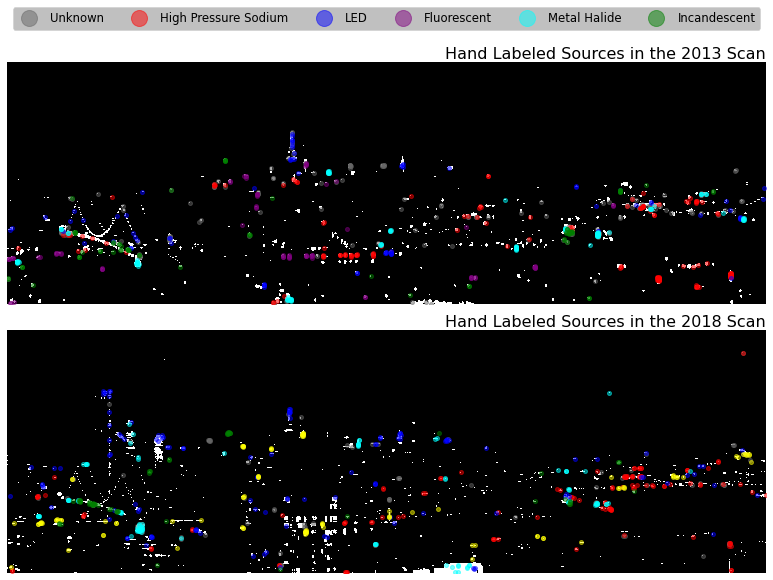

In [17]:

fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(Unknown_label_hsi0.x, Unknown_label_hsi0.y, marker="o", linestyle='', ms=4, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(HPS_label_hsi0.x, HPS_label_hsi0.y, marker='o', linestyle='', ms=4, c = "red", label = 'High Pressure Sodium', alpha = 0.5)
ax[0].plot(LED_label_hsi0.x, LED_label_hsi0.y, marker='o', linestyle='',ms=4, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(CFL_label_hsi0.x, CFL_label_hsi0.y, marker='o', linestyle='', ms=4, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_label_hsi0.x, MH_label_hsi0.y, marker='o', linestyle='', ms=4, c = "cyan", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_label_hsi0.x, INC_label_hsi0.y, marker='o', linestyle='',ms=4, c = "green", label = 'Incandescent', alpha = 0.5)
ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)

ax[0].axis('off')
ax[0].set_facecolor("#444444")

ax[0].set_title("Hand Labeled Sources in the 2013 Scan", loc = "right", fontsize=16)




ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")

ax[1].plot(Unknown_label_hsi1.x, Unknown_label_hsi1.y, marker="o", linestyle='', ms=4, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(HPS_label_hsi1.x, HPS_label_hsi1.y, marker='o', linestyle='', ms=4, c = "red", label = 'High Pressure Sodium', alpha = 0.5)
ax[1].plot(LED_label_hsi1.x, LED_label_hsi1.y, marker='o', linestyle='', ms=4, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(CFL_label_hsi1.x, CFL_label_hsi1.y, marker='o', linestyle='', ms=4, c = "yellow", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_label_hsi1.x, MH_label_hsi1.y, marker='o', linestyle='', ms=4, c = "cyan", label = 'Metal Halide', alpha = 0.5)
ax[1].plot(INC_label_hsi1.x, INC_label_hsi1.y, marker='o', linestyle='', ms=4, c = "green", label = 'Incandescent', alpha = 0.5)

ax[1].axis('off')

ax[1].set_title("Hand Labeled Sources in the 2018 Scan", loc = "right", fontsize=16)
fig.tight_layout()

In [7]:
# -- normlize raw data 
def norm(feat):

  """
  Read source spectra

  Parameters:
  ----------
  feat: a two dimentional array of source spectra

  Returns:
  -------
  a two dimentional array
  normlized source spectra
  
  """
  feat_norm = np.empty(feat.shape)
  for i in range(0, len(feat)):
    norm = (feat[i] - feat[i].min()) / (feat[i].max() - feat[i].min())
    feat_norm[i, :] = norm
  return feat_norm

cnn_hsi1_spec_norm = norm(cnn_hsi1_spec)
cnn_hsi0_spec_norm = norm(cnn_hsi0_inter)


# -- combine both scans' feature 
feat = np.vstack([cnn_hsi0_spec_norm, cnn_hsi1_spec_norm])

In [8]:
feat.shape

(1329, 848)

In [9]:
# -- get target  
target_hsi1 = targ_hsi1.astype(str)
target_hsi0 = targ_hsi0.astype(str)

# -- hsi1
target_dict = {'High_Pressure_Sodium': 0,'LED': 1, 'Fluorescent': 2,'Metal_Halide': 3, 'Incandescent': 4, "Unknown" :5 }
target_hsi1 = np.array([target_dict[item] for item in target_hsi1]).astype("int")
target_hsi1

# -- hsi0
target_hsi0 = np.array([target_dict[item] for item in target_hsi0]).astype("int")
target_hsi0

# -- combine both scans' target
target = np.concatenate([target_hsi0, target_hsi1])
target.shape

(1329,)

In [10]:
# -- combine the locations
loc_all = np.vstack([loc_hsi0, loc_hsi1])

# -- add locations to all spectra
feat_loc = np.hstack([feat, loc_all])

# --add locations to each image
cnn_hsi0_spec_norm_loc = np.hstack([cnn_hsi0_spec_norm, loc_hsi0])
cnn_hsi1_spec_norm_loc = np.hstack([cnn_hsi1_spec_norm, loc_hsi1])


In [11]:
cnn_hsi0_spec_norm_loc.shape

(713, 850)

In [12]:
# -- add target to each image
hsi1 = pd.DataFrame(cnn_hsi1_spec_norm_loc).rename(columns=str)
hsi1["target"] = target_hsi1


hsi0 = pd.DataFrame(cnn_hsi0_spec_norm_loc).rename(columns=str)
hsi0["target"] = target_hsi0

In [13]:
hsi1.shape

(616, 851)

In [14]:
# -- create a training and testing set
feature = feat_loc
targ = target

feat_tr, feat_te, targ_tr, targ_te = train_test_split(feature, targ, test_size=0.2, random_state=302)

# -- check the shapes of the data
print("training set shape : ", feat_tr.shape)
print("testing set shape  : ", feat_te.shape)

training set shape :  (1063, 850)
testing set shape  :  (266, 850)


In [15]:
hsi0.shape

(713, 851)

In [17]:
# -- finding the testing data in hsi0 and hsi1 image
feat_te_df = pd.DataFrame(feat_te).rename(columns=str)

# -- for hsi0
hsi0_te = hsi0.merge(feat_te_df, on=["100", "200", "300", "400", "500", "600", "700", "848","849"],how='left', indicator=True)
hsi0_te = hsi0_te[hsi0_te["_merge"] == "both"]
hsi0_te_spec = np.array(hsi0_te)[:, :848].astype('float64')
hsi0_te_targ = np.array(hsi0_te)[:, 850].astype('int64')


# -- for hsi1
hsi1_te = hsi1.merge(feat_te_df, on=["100", "200", "300", "400", "500", "600", "700", "848","849"],
                   how='left', indicator=True)
hsi1_te = hsi1_te[hsi1_te["_merge"] == "both"]
hsi1_te_spec = np.array(hsi1_te)[:, :848].astype('float64')
hsi1_te_targ = np.array(hsi1_te)[:, 850].astype('int64')

In [18]:
# -- reshape the training and testing data
feat_tr_spec = feat_tr[:, :848]
feat_tr_spec = feat_tr_spec.reshape(feat_tr_spec.shape[0], 848, 1)

hsi0_te_spec = hsi0_te_spec.reshape(hsi0_te_spec.shape[0], 848, 1)
hsi1_te_spec = hsi1_te_spec.reshape(hsi1_te_spec.shape[0], 848, 1)

In [19]:
# -- check the shapes of the data
print("training set shape : ", feat_tr_spec.shape)
print("testing set shape  : ", hsi0_te_spec.shape)
print("testing set shape  : ", hsi1_te_spec.shape)

training set shape :  (1063, 848, 1)
testing set shape  :  (137, 848, 1)
testing set shape  :  (129, 848, 1)


In [20]:
# -- Testing data in this model are the spectra come from both scans
# -- the testing data in this model are the spectra come from both scans

layer1 = keras.layers.Conv1D(64, kernel_size=(25), padding="same", activation="relu", input_shape=(848, 1))
layer2 = keras.layers.MaxPooling1D(6, strides=5)
layer3 = keras.layers.Conv1D(518, kernel_size=(25), padding="same", activation="relu") 
layer4 = keras.layers.MaxPooling1D(6, strides=5)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(1024, activation="relu")
layer7 = keras.layers.Dense(6, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate a "simple" convolutional neural network
model = keras.Sequential(layers)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])



# -- fit the model
history = model.fit(feat_tr_spec, targ_tr, epochs=20, batch_size=20)



# -- print the accuracy
loss_tr, acc_tr = model.evaluate(feat_tr_spec, targ_tr)
loss_te_hsi0, acc_te_hsi0 = model.evaluate(hsi0_te_spec, hsi0_te_targ)
loss_te_hsi1, acc_te_hsi1 = model.evaluate(hsi1_te_spec, hsi1_te_targ)


# loss_te_hsi0, acc_te_hsi0 = model.evaluate(cnn_hsi0_spec_norm2, target_hsi0)
# loss_te_hsi1, acc_te_hsi1 = model.evaluate(cnn_hsi1_spec_norm2, target_hsi1)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testining accuracy_hsi0 : {0:.4f}".format(acc_te_hsi0))
print("Testining accuracy_hsi1 : {0:.4f}".format(acc_te_hsi1))

Epoch 1/20


2023-07-26 22:36:32.805944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 22:36:32.856270: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-07-26 22:36:32.856292: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-07-26 22:36:32.856758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

54/54 [==============================] - 3s 52ms/step - loss: 0.7132 - accuracy: 0.7366
Epoch 2/20
54/54 [==============================] - 3s 52ms/step - loss: 0.3267 - accuracy: 0.8815
Epoch 3/20
54/54 [==============================] - 3s 51ms/step - loss: 0.2820 - accuracy: 0.8862
Epoch 4/20
54/54 [==============================] - 3s 52ms/step - loss: 0.2269 - accuracy: 0.9125
Epoch 5/20
54/54 [==============================] - 3s 52ms/step - loss: 0.2715 - accuracy: 0.8937
Epoch 6/20
54/54 [==============================] - 3s 52ms/step - loss: 0.1823 - accuracy: 0.9276
Epoch 7/20
54/54 [==============================] - 3s 52ms/step - loss: 0.1903 - accuracy: 0.9219
Epoch 8/20
54/54 [==============================] - 3s 51ms/step - loss: 0.1715 - accuracy: 0.9294
Epoch 9/20
54/54 [==============================] - 3s 51ms/step - loss: 0.1105 - accuracy: 0.9577
Epoch 10/20
54/54 [==============================] - 3s 52ms/step - loss: 0.0864 - accuracy: 0.9718
Epoch 11/20
54/54 [=

In [21]:
from sklearn.metrics import classification_report

In [22]:
# print classification_report
target_names = ['High_Pressure_Sodium','LED', 'Fluorescent','Metal_Halide', 'Incandescent', 'unknown']

pred_te_hsi0 = model.predict(hsi0_te_spec)
pred_te_hsi1 = model.predict(hsi1_te_spec)

5/5 [==============================] - 0s 10ms/step


In [23]:
pred_te_hsi0_matrix = [pred_te_hsi0[i].argmax() for i in range(len(pred_te_hsi0))]
print(classification_report(hsi0_te_targ, pred_te_hsi0_matrix, target_names = target_names))

                      precision    recall  f1-score   support

High_Pressure_Sodium       0.97      0.97      0.97        31
                 LED       0.93      0.87      0.90        15
         Fluorescent       1.00      1.00      1.00        18
        Metal_Halide       0.96      0.92      0.94        24
        Incandescent       0.95      1.00      0.97        18
             unknown       0.84      0.87      0.86        31

            accuracy                           0.93       137
           macro avg       0.94      0.94      0.94       137
        weighted avg       0.93      0.93      0.93       137



In [25]:
pred_te_hsi1_matrix = [pred_te_hsi1[i].argmax() for i in range(len(pred_te_hsi1))]
print(classification_report(hsi1_te_targ, pred_te_hsi1_matrix, target_names = target_names))

                      precision    recall  f1-score   support

High_Pressure_Sodium       0.91      0.97      0.94        30
                 LED       0.88      0.95      0.91        22
         Fluorescent       0.95      1.00      0.98        21
        Metal_Halide       0.85      1.00      0.92        17
        Incandescent       0.93      1.00      0.97        14
             unknown       0.94      0.60      0.73        25

            accuracy                           0.91       129
           macro avg       0.91      0.92      0.91       129
        weighted avg       0.91      0.91      0.90       129



In [31]:
# the testing data in this model are only from the 2015 scan


In [32]:
# -- create a training and testing set
feature = cnn_hsi0_spec_norm
targ = target_hsi0

feat_tr, feat_te, targ_tr, targ_te = train_test_split(feature, targ, test_size=0.2, random_state=302)

In [33]:
# -- define the network
layer1 = keras.layers.Conv1D(64, kernel_size=(25), padding="same", activation="relu", input_shape=(848, 1))
layer2 = keras.layers.MaxPooling1D(6, strides=5)
layer3 = keras.layers.Conv1D(518, kernel_size=(25), padding="same", activation="relu")
layer4 = keras.layers.MaxPooling1D(6, strides=5)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(1024, activation="relu")
layer7 = keras.layers.Dense(6, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate a "simple" convolutional neural network
model_hsi0 = keras.Sequential(layers)
model_hsi0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- feautres need to have an extra axis on the end (for mini-batching)
feat_tr = feat_tr.reshape(feat_tr.shape[0], 848, 1)
feat_te = feat_te.reshape(feat_te.shape[0], 848, 1)

cnn_hsi1_spec_norm2 = cnn_hsi1_spec_norm.reshape(616, 848, 1)


# -- fit the model
history_hsi0 = model_hsi0.fit(feat_tr, targ_tr, epochs=20, batch_size=20)


# -- print the accuracy
loss_tr_hsi0, acc_tr_hsi0 = model_hsi0.evaluate(feat_tr, targ_tr)

loss_te_hsi0, acc_te_hsi0 = model_hsi0.evaluate(feat_te, targ_te)
loss_te_hsi1, acc_te_hsi1 = model_hsi0.evaluate(cnn_hsi1_spec_norm2, target_hsi1)

print("Training accuracy hsi0 : {0:.4f}".format(acc_tr_hsi0))
print("Testing accuracy hsi0 : {0:.4f}".format(acc_te_hsi0))
print("Testing accuracy hsi1 : {0:.4f}".format(acc_te_hsi1))

Epoch 1/20
29/29 [==============================] - 2s 49ms/step - loss: 1.0369 - accuracy: 0.5982
Epoch 2/20
29/29 [==============================] - 1s 49ms/step - loss: 0.4013 - accuracy: 0.8684
Epoch 3/20
29/29 [==============================] - 1s 50ms/step - loss: 0.3167 - accuracy: 0.8649
Epoch 4/20
29/29 [==============================] - 1s 51ms/step - loss: 0.2510 - accuracy: 0.8965
Epoch 5/20
29/29 [==============================] - 1s 50ms/step - loss: 0.2235 - accuracy: 0.9105
Epoch 6/20
29/29 [==============================] - 1s 50ms/step - loss: 0.1928 - accuracy: 0.9193
Epoch 7/20
29/29 [==============================] - 1s 49ms/step - loss: 0.1297 - accuracy: 0.9509
Epoch 8/20
29/29 [==============================] - 2s 52ms/step - loss: 0.2859 - accuracy: 0.8947
Epoch 9/20
29/29 [==============================] - 1s 51ms/step - loss: 0.1886 - accuracy: 0.9333
Epoch 10/20
29/29 [==============================] - 1s 51ms/step - loss: 0.1490 - accuracy: 0.9368
Epoch 11/

In [34]:
pred_te_hsi0 = model_hsi0.predict(feat_te)
pred_tr_hsi0 = model_hsi0.predict(feat_tr)

pred_te_hsi1 = model_hsi0.predict(cnn_hsi1_spec_norm2)

20/20 [==============================] - 0s 11ms/step


In [37]:
pred_te_matrix_model0 = [pred_te_hsi0[i].argmax() for i in range(len(pred_te_hsi0))]
print(classification_report(targ_te, pred_te_matrix_model0, target_names = target_names))

                      precision    recall  f1-score   support

High_Pressure_Sodium       0.94      1.00      0.97        29
                 LED       0.95      0.95      0.95        19
         Fluorescent       1.00      1.00      1.00        16
        Metal_Halide       1.00      0.90      0.95        31
        Incandescent       1.00      1.00      1.00        13
             unknown       0.89      0.91      0.90        35

            accuracy                           0.95       143
           macro avg       0.96      0.96      0.96       143
        weighted avg       0.95      0.95      0.95       143



In [38]:
pred_te_matrix_model0 = [pred_te_hsi1[i].argmax() for i in range(len(pred_te_hsi1))]
print(classification_report(target_hsi1, pred_te_matrix_model0, target_names = target_names))

                      precision    recall  f1-score   support

High_Pressure_Sodium       0.94      0.87      0.90       119
                 LED       0.74      0.98      0.84       123
         Fluorescent       0.93      0.95      0.94       103
        Metal_Halide       1.00      0.68      0.81       106
        Incandescent       0.93      0.61      0.74        62
             unknown       0.55      0.68      0.61       103

            accuracy                           0.81       616
           macro avg       0.85      0.79      0.81       616
        weighted avg       0.84      0.81      0.82       616



In [39]:
# -- create a training and testing set
feature = cnn_hsi1_spec_norm
targ = target_hsi1

feat_tr, feat_te, targ_tr, targ_te = train_test_split(feature, targ, test_size=0.2, random_state=302)

In [40]:
# -- define the network
layer1 = keras.layers.Conv1D(64, kernel_size=(25), padding="same", activation="relu", input_shape=(848, 1))
layer2 = keras.layers.MaxPooling1D(6, strides=5)
layer3 = keras.layers.Conv1D(518, kernel_size=(25), padding="same", activation="relu")
layer4 = keras.layers.MaxPooling1D(6, strides=5)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(1024, activation="relu")
layer7 = keras.layers.Dense(6, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate a "simple" convolutional neural network
model_hsi1 = keras.Sequential(layers)
model_hsi1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])



# -- feautres need to have an extra axis on the end (for mini-batching)
feat_tr = feat_tr.reshape(feat_tr.shape[0], 848, 1)
feat_te = feat_te.reshape(feat_te.shape[0], 848, 1)

cnn_hsi0_spec_norm2 = cnn_hsi0_spec_norm.reshape(cnn_hsi0_spec_norm.shape[0], 848, 1)

# -- fit the model

history_hsi1 = model_hsi1.fit(feat_tr, targ_tr, epochs=20, batch_size=20)


# -- print the accuracy
loss_tr_hsi1, acc_tr_hsi1 = model_hsi1.evaluate(feat_tr, targ_tr)
loss_te_hsi1, acc_te_hsi1 = model_hsi1.evaluate(feat_te, targ_te)
loss_te_hsi10, acc_te_hsi0 = model_hsi1.evaluate(cnn_hsi0_spec_norm2, target_hsi0)

print("Training accuracy hsi1 : {0:.4f}".format(acc_tr_hsi1))
print("Testing accuracy hsi1 : {0:.4f}".format(acc_te_hsi1))
print("Testing accuracy hsi0 : {0:.4f}".format(acc_te_hsi0))



Epoch 1/20
25/25 [==============================] - 1s 50ms/step - loss: 0.9195 - accuracy: 0.6545
Epoch 2/20
25/25 [==============================] - 1s 51ms/step - loss: 0.4474 - accuracy: 0.8516
Epoch 3/20
25/25 [==============================] - 1s 50ms/step - loss: 0.2858 - accuracy: 0.8963
Epoch 4/20
25/25 [==============================] - 1s 50ms/step - loss: 0.2047 - accuracy: 0.9390
Epoch 5/20
25/25 [==============================] - 1s 51ms/step - loss: 0.1596 - accuracy: 0.9512
Epoch 6/20
25/25 [==============================] - 1s 50ms/step - loss: 0.1411 - accuracy: 0.9533
Epoch 7/20
25/25 [==============================] - 1s 50ms/step - loss: 0.1594 - accuracy: 0.9573
Epoch 8/20
25/25 [==============================] - 1s 50ms/step - loss: 0.0962 - accuracy: 0.9675
Epoch 9/20
25/25 [==============================] - 1s 51ms/step - loss: 0.1128 - accuracy: 0.9614
Epoch 10/20
25/25 [==============================] - 1s 51ms/step - loss: 0.0814 - accuracy: 0.9695
Epoch 11/

In [60]:
pred_hsi1_model1 = model_hsi1.predict(feat_te)
pred_hsi0_model1 = model_hsi1.predict(cnn_hsi0_spec_norm2)


23/23 [==============================] - 0s 11ms/step


In [63]:
pred_hsi0_matrix_model1 = [pred_hsi0_model1[i].argmax() for i in range(len(pred_hsi0_model1))]
print(classification_report(target_hsi0, pred_hsi0_matrix_model1, target_names = target_names))

                      precision    recall  f1-score   support

High_Pressure_Sodium       0.76      0.96      0.85       158
                 LED       0.82      0.85      0.84        75
         Fluorescent       0.92      1.00      0.96        81
        Metal_Halide       0.83      0.94      0.88       117
        Incandescent       0.81      0.99      0.89        83
             unknown       0.86      0.50      0.63       199

            accuracy                           0.82       713
           macro avg       0.83      0.87      0.84       713
        weighted avg       0.83      0.82      0.81       713



In [64]:
pred_hsi1_matrix_model1 = [pred_hsi1_model1[i].argmax() for i in range(len(pred_hsi1_model1))]
print(classification_report(targ_te, pred_hsi1_matrix_model1, target_names = target_names)) 

                      precision    recall  f1-score   support

High_Pressure_Sodium       1.00      1.00      1.00        22
                 LED       0.97      0.91      0.94        32
         Fluorescent       0.94      1.00      0.97        15
        Metal_Halide       1.00      1.00      1.00        23
        Incandescent       0.92      1.00      0.96        11
             unknown       0.86      0.86      0.86        21

            accuracy                           0.95       124
           macro avg       0.95      0.96      0.95       124
        weighted avg       0.95      0.95      0.95       124



In [65]:
# --now, let's use the model with testing data from both scans to do our prediction
# -- load raw spec data for both scan
hsi1_spec = np.load("../output/hsi1_overlap_cnn_allwave_bridge.npy").T
hsi0_spec = np.load("../output/hsi0_overlap_cnn_allwave_bridge.npy").T

# -- interpolate the hsi0 spectra 
hsi0_inter = np.empty((len(hsi0_spec), len(waves1)))
for i in range(0, len(hsi0_spec)):
    interp = np.interp(waves1, waves0, (hsi0_spec)[i])
    hsi0_inter[i,:] = (interp)

In [69]:
hsi1_spec.shape

(15453, 848)

In [66]:
# -- normalize raw data 
hsi0_norm = norm(hsi0_inter)
hsi1_norm = norm(hsi1_spec)

# -- reshape stan spec data and then pred
nrow_hsi0, ncol_hsi0 = hsi0_norm.shape
nrow_hsi1, ncol_hsi1 = hsi1_norm.shape

hsi0_norm = hsi0_norm.reshape(nrow_hsi0, ncol_hsi0, 1)
hsi1_norm = hsi1_norm.reshape(nrow_hsi1, ncol_hsi1, 1)

# -- prediction
pred_hsi0 = model.predict(hsi0_norm)
pred_hsi1 = model.predict(hsi1_norm)

# -- get the max prob predicted lighting type 
pred_hsi0_type = pred_hsi0.argmax(axis=1)
pred_hsi1_type = pred_hsi1.argmax(axis=1)

483/483 [==============================] - 5s 9ms/step


In [70]:
# -- create df for both scan including active pixel location and lighting type
pred_light_hsi0 = pd.DataFrame()
pred_light_hsi1 = pd.DataFrame()

# -- load location data
hsi1_loc = np.load("../output/hsi1_overlap_location_bridge.npy")
hsi0_loc = np.load("../output/hsi0_overlap_location_bridge.npy")


# -- include location and lighting type data
pred_dict = {0 : 'High_Pressure_Sodium', 1 : 'LED', 2 : 'Fluorescent', 3 : 'Metal_Halide', 4 : 'Incandescent', 5:"Unknown"}

pred_hsi0_type = [pred_dict[item] for item in pred_hsi0_type] # -- get name of each type
pred_light_hsi0["pred"] = pred_hsi0_type 

pred_light_hsi0["loc_x"] = hsi0_loc[:, 1]
pred_light_hsi0["loc_y"] = hsi0_loc[:, 0]

pred_hsi1_type = [pred_dict[item] for item in pred_hsi1_type]
pred_light_hsi1["pred"] = pred_hsi1_type  
pred_light_hsi1["loc_x"] = hsi1_loc[:, 1]
pred_light_hsi1["loc_y"] = hsi1_loc[:, 0]

In [71]:
# -- plot filtered scans and prediction


imgL_hsi1 = np.load("../output/img_L1_fnl_zoom.npy")
imgL_hsi0 = np.load("../output/graham_hall_upload/imgL0_overlap.npy")

# # -- create five categories
# # -- hsi1
INC_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Incandescent")]
HPS_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("High_Pressure_Sodium")]
LED_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("LED")]
CFL_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Fluorescent")]
MH_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Metal_Halide")]
unknown_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Unknown")]


# # -- hsi0
INC_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Incandescent")]
HPS_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("High_Pressure_Sodium")]
LED_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("LED")]
CFL_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Fluorescent")]
MH_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Metal_Halide")]
unknown_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Unknown")]

In [72]:
unknown_hsi0.shape

(10262, 3)

In [75]:
hsi0_spec.shape

(15075, 872)

In [76]:
15075 - 10262

4813

In [77]:
unknown_hsi1.shape

(3295, 3)

In [78]:
hsi1_spec.shape

(15453, 848)

In [79]:
15453-3295

12158

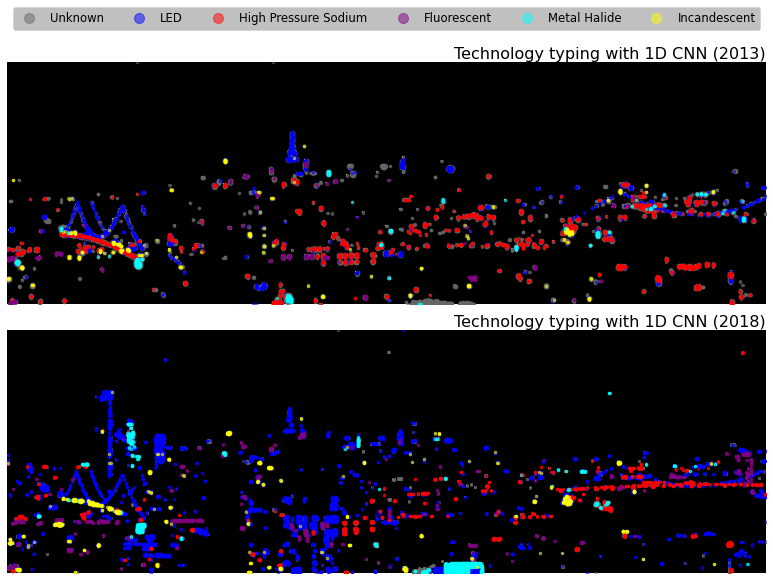

In [80]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology typing with 1D CNN (2013)", loc = "right", fontsize = 16)

# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology typing with 1D CNN (2018)", loc = "right", fontsize = 16)
fig.tight_layout()

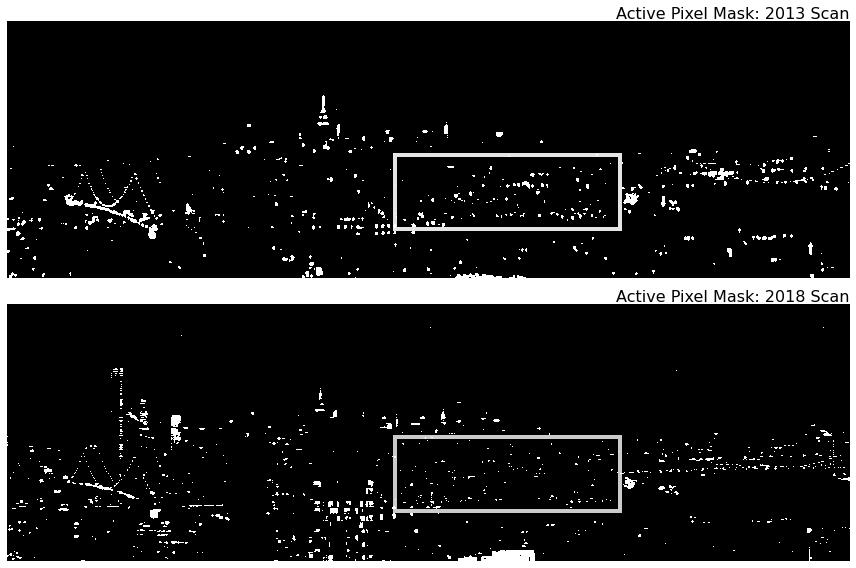

In [81]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

# ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="s", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
# ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
# ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

# ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
# ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal Halide', alpha = 0.5)
# ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

# ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Active Pixel Mask: 2013 Scan", loc = "right", fontsize = 16)

rect1 = patches.Rectangle((500, 360), 290, 200, linewidth=4, edgecolor='white', facecolor = 'none',zorder = 7, alpha = 0.9)
ax[0].add_patch(rect1)


# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
# ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
# ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
# ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

# ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
# ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal_Halide', alpha = 0.5)
# ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
rect1 = patches.Rectangle((500, 360), 290, 200, linewidth=4, edgecolor='white', facecolor = 'none', zorder = 7, alpha = 0.8)

ax[1].add_patch(rect1)
#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Active Pixel Mask: 2018 Scan", loc = "right", fontsize = 16)
fig.tight_layout()

In [82]:
imgL_hsi0.shape

(695, 1087)

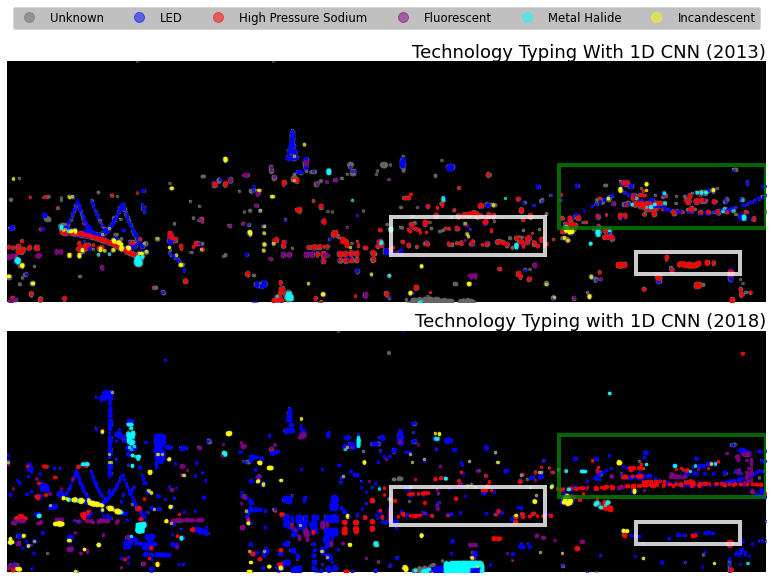

In [83]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology Typing With 1D CNN (2013)", loc = "right", fontsize = 18)

rect1 = patches.Rectangle((550, 450), 220, 110,  linewidth=4, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[0].add_patch(rect1)

rect2 = patches.Rectangle((900, 550), 150, 65,  linewidth=4, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[0].add_patch(rect2)

rect3 = patches.Rectangle((790, 300), 297, 180,  linewidth=4, edgecolor='green', facecolor='none', zorder = 7, alpha = 0.8)
ax[0].add_patch(rect3)

# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
rect3 = patches.Rectangle((550, 450), 220, 110,  linewidth=4, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[1].add_patch(rect3)

rect4 = patches.Rectangle((900, 550), 150, 65,  linewidth=4, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[1].add_patch(rect4)

rect5 = patches.Rectangle((790, 300), 296, 180,  linewidth=4, edgecolor='green', facecolor='none', zorder = 7, alpha = 0.8)
ax[1].add_patch(rect5)
#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology Typing with 1D CNN (2018)", loc = "right", fontsize = 18)
fig.tight_layout()

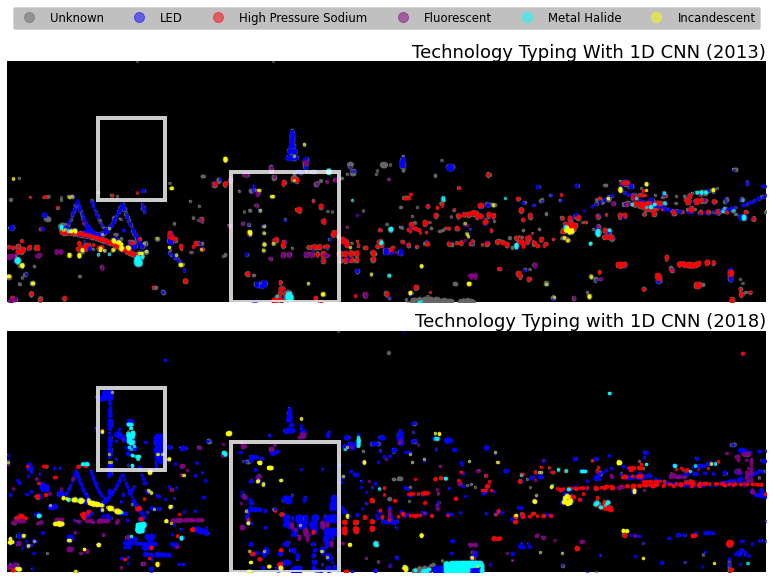

In [84]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology Typing With 1D CNN (2013)", loc = "right", fontsize = 18)

rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[0].add_patch(rect2)
rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[0].add_patch(rect)

# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[1].add_patch(rect2)
rect = patches.Rectangle((320, 320), 155, 374, linewidth=4,edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[1].add_patch(rect)
#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')


ax[1].set_title("Technology Typing with 1D CNN (2018)", loc = "right", fontsize = 18)
fig.tight_layout()

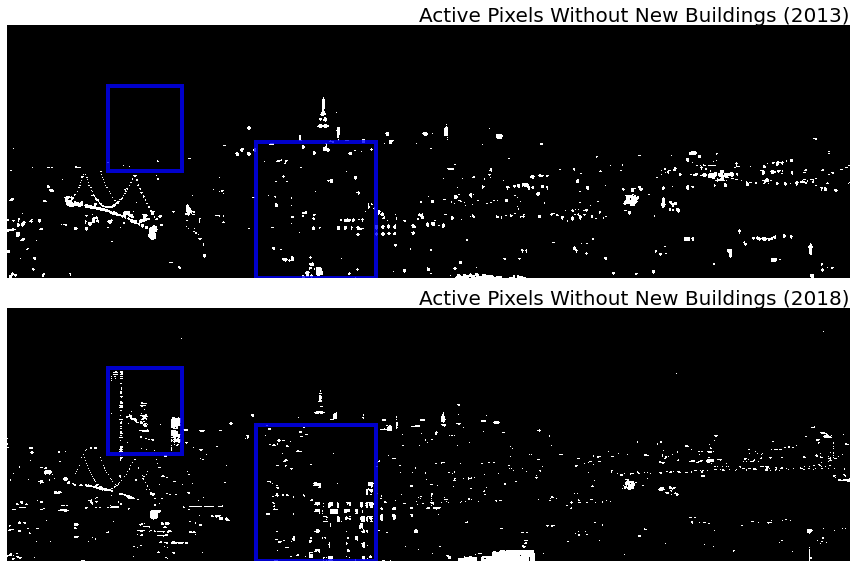

In [85]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Active Pixels Without New Buildings (2013)", loc = "right", fontsize = 20)

rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='blue', facecolor='none', zorder = 9, alpha = 0.8)
ax[0].add_patch(rect2)
rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='blue', facecolor='none', zorder = 9, alpha = 0.8)
ax[0].add_patch(rect)


# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")

rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='blue', facecolor='none', zorder = 9, alpha = 0.8)
ax[1].add_patch(rect2)
rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='blue', facecolor='none', zorder = 9, alpha = 0.8)
ax[1].add_patch(rect)

#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Active Pixels Without New Buildings (2018)", loc = "right", fontsize = 20)
fig.tight_layout()

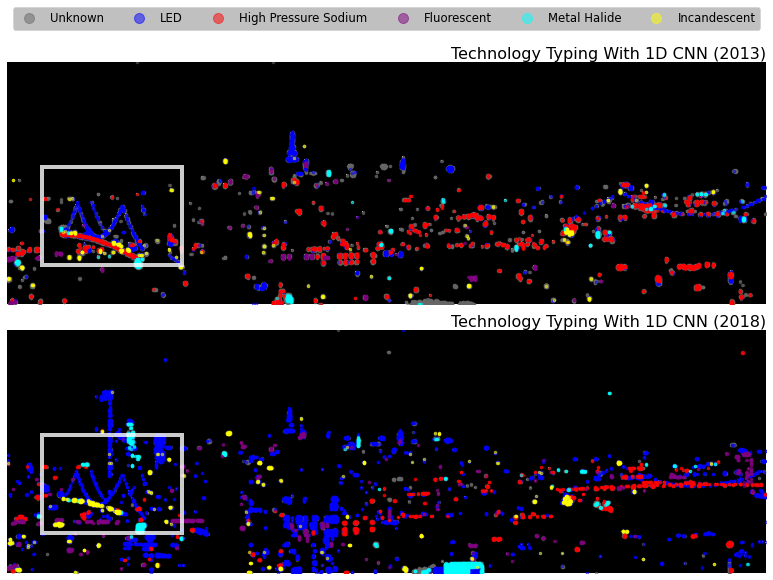

In [86]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology Typing With 1D CNN (2013)", loc = "right", fontsize = 16)

# rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
# ax[0].add_patch(rect2)
# rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
# ax[0].add_patch(rect)

rect = patches.Rectangle((50, 300), 200, 280, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
ax[0].add_patch(rect)


# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
# rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
# ax[1].add_patch(rect2)
# rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
# ax[1].add_patch(rect)
rect = patches.Rectangle((50, 300), 200, 280, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
ax[1].add_patch(rect)
#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology Typing With 1D CNN (2018)", loc = "right", fontsize = 16)
fig.tight_layout()

In [87]:
rgb_tech_hsi1 = np.zeros((695, 1087, 3))
rgb_tech_hsi0 = np.zeros((695, 1087, 3))


def get_rbg_loc(rgb_tech, src, r, g, b):
  for i in range(len(src)):
      rgb_tech[src.iloc[i].loc_y, src.iloc[i].loc_x] = (r, g, b)
  return rgb_tech

In [88]:

rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, unknown_hsi0, 1, 1, 1)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, HPS_hsi0, 1, 0, 0)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, LED_hsi0, 0, 0, 1)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, CFL_hsi0, 1, 0.6, 1)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, MH_hsi0, 0, 1, 1)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, INC_hsi0, 1, 1, 0)


rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, unknown_hsi1, 1, 1, 1)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, HPS_hsi1, 1, 0, 0)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, LED_hsi1, 0, 0, 1)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, CFL_hsi1, 0, 0.6, 0)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, MH_hsi1, 0, 1, 1)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, INC_hsi1, 1, 1, 0)

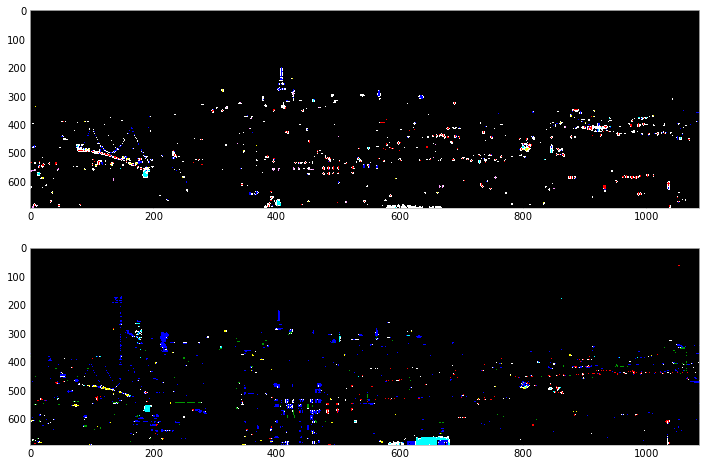

In [89]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(rgb_tech_hsi0, aspect="auto")
ax[1].imshow(rgb_tech_hsi1, aspect="auto")

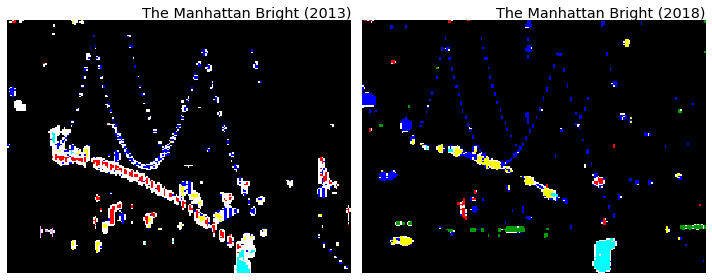

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
ax[0].imshow(rgb_tech_hsi0[390:580, 50:250], aspect="auto")
ax[0].axis('off')
ax[0].set_title("The Manhattan Bright (2013)", loc = "right")

ax[1].axis('off')
ax[1].imshow(rgb_tech_hsi1[390:580, 50:250], aspect="auto")
ax[1].set_title("The Manhattan Bright (2018)", loc = "right")
fig.tight_layout()
# ax[0, 1].imshow(rgb_tech_hsi0[400:590, 450:800], aspect="auto")
# ax[0, 1].axis('off')
# ax[0, 1].set_title("Residential Area", loc = "right")

# ax[1, 1].axis('off')
# ax[1, 1].imshow(rgb_tech_hsi1[400:590, 450:800], aspect="auto")

# ax[0, 2].imshow(rgb_tech_hsi0[300:500, 800:], aspect="auto")
# ax[0, 2].set_title("The Williamsburg Bright", loc = "right")
# ax[0, 2].axis('off')
# ax[1, 2].axis('off')
# ax[1, 2].imshow(rgb_tech_hsi1[300:500, 800:], aspect="auto")

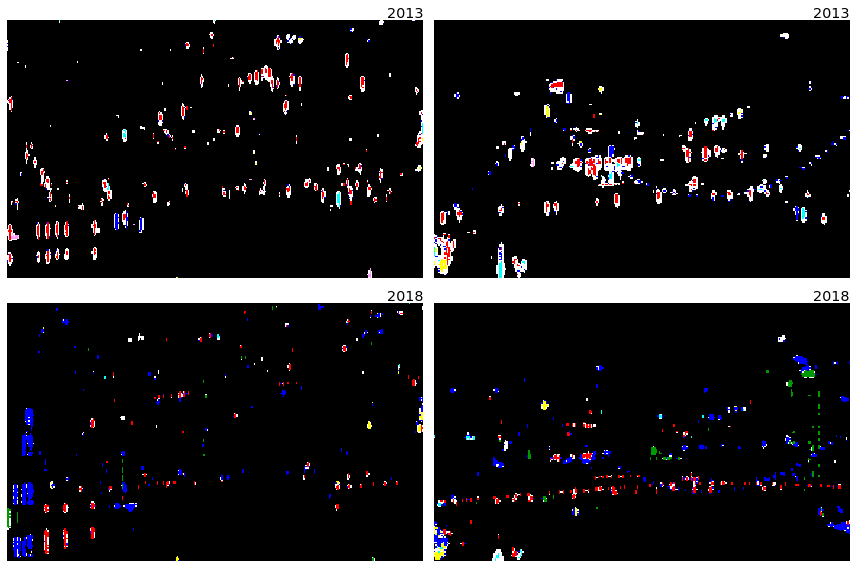

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12, 8))

ax[0, 0].imshow(rgb_tech_hsi0[400:590, 450:800], aspect="auto")
ax[0, 0].axis('off')
ax[0, 0].set_title("2013", loc = "right")

ax[1, 0].axis('off')
ax[1, 0].set_title("2018", loc = "right")
ax[1, 0].imshow(rgb_tech_hsi1[400:590, 450:800], aspect="auto")

ax[0, 1].imshow(rgb_tech_hsi0[300:500, 800:], aspect="auto")
ax[0, 1].axis('off')
ax[0, 1].set_title("2013", loc = "right")

ax[1, 1].axis('off')
ax[1, 1].imshow(rgb_tech_hsi1[300:500, 800:], aspect="auto")
ax[1, 1].set_title("2018", loc = "right")

fig.tight_layout()


# ax[0, 2].imshow(rgb_tech_hsi0[300:500, 800:], aspect="auto")
# ax[0, 2].set_title("The Williamsburg Bright", loc = "right")
# ax[0, 2].axis('off')
# ax[1, 2].axis('off')
# ax[1, 2].imshow(rgb_tech_hsi1[300:500, 800:], aspect="auto")

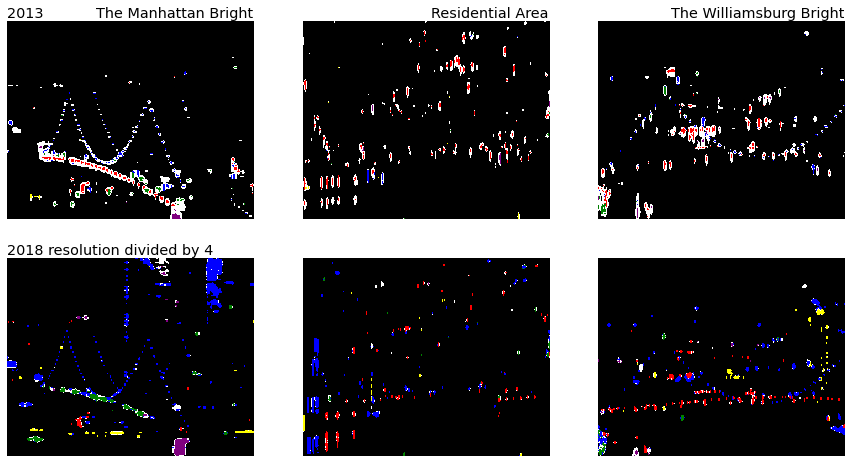

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize = (15, 8))
ax[0, 0].imshow(rgb_tech_hsi0[300:580, 50:250], aspect="auto")
ax[0, 0].axis('off')
ax[0, 0].set_title("The Manhattan Bright", loc = "right")
ax[0, 0].set_title("2013", loc = "left")

ax[1, 0].axis('off')
ax[1, 0].set_title("2018 resolution divided by 4", loc = "left")
ax[1, 0].imshow(rgb_tech_hsi1[300:580, 50:250], aspect="auto")

ax[0, 1].imshow(rgb_tech_hsi0[400:590, 450:800], aspect="auto")
ax[0, 1].axis('off')
ax[0, 1].set_title("Residential Area", loc = "right")

ax[1, 1].axis('off')
ax[1, 1].imshow(rgb_tech_hsi1[400:590, 450:800], aspect="auto")

ax[0, 2].imshow(rgb_tech_hsi0[300:500, 800:], aspect="auto")
ax[0, 2].set_title("The Williamsburg Bright", loc = "right")
ax[0, 2].axis('off')
ax[1, 2].axis('off')
ax[1, 2].imshow(rgb_tech_hsi1[300:500, 800:], aspect="auto")